# Chapter 3 Data Preparation

## The Problem Understanding Phase

It's important to know *what* questions you are trying to answer.

### Objectives

1.  Learn about potential customers. What are the defining characteristics of those who both do and do not bank with us?
2.  Develop a way to identify customers who are likely to bank with us in the future. This will save time and money by preventing our chasing customers who will likely not choose us in the future.

### Translating These Objectives into a Data Science Problem

How do we use DS to accomplish our objectives?

1.  There are many ways to learn about potential customers.
    1.  Exploratory Data Analysis to find relationships among variables. (ex. a histogram of age overlaid with responses to a yes/no question to determine if age has a bearing on customer response.)
    2.  Use clustering to find any potential natural groupings within potential customers. (ex. group younger/better-educated vs older/less-educated and see if these clusters differ in their response to our marketing.)
    3.  Use association rules to see if there are useful relationships between subsets of records. (ex. if the rule, "if cell phone, then response = "yes" we could focus our efforts on only those potential customers who have cell phones.)
2.  Develop models to identify likely positive respondents. Note that because the yes/no response is categorical we can use classification models but *not* estimation models.
    1.  Develop the best models we can using the following algorithms:
        -   decision trees
        -   random forests
        -   naive Bayes classification
        -   neural networks
        -   logistic regression
    2.  Evaluate each model on some predetermined criteria (such as the cost of misclassification). and compare the models against each other.
    3.  Consult with management regarding our findings.

## The Data Preparation Phase

Every data set has its own, unique needs in terms of cleaning and preparation. In this chapter we will focus on:

-   adding an index field
-   changing misleading field values
-   re-expressing categorical data as numeric
-   standardizing the numeric fields
-   identifying outliers

## Adding an Index Field

Not all data sets include a natural ID or indexing variable. It's useful to add on to:

1.  have some way to identify each observation
2.  be able to restore the original ordering of the data set

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import stats

In [ ]:
bank_train = pd.read_csv("bank_marketing_training")

We first need to know how many observations there are in our data set. `.shape` will get number of rows and columns that are in the data set.

In [ ]:
bank_train.shape

Next, we create a new variable to serve as the index. I prefer my index variable to be in the first column.

In [ ]:
bank_train.insert(0, "index", pd.Series(range(bank_train.shape[0])))

bank_train.head()

## Changing Misleading Field Values

The variable *days_since_previous* is a count of the number of days since the client was last contacted. The field is numeric so we can use a histogram to visualize and sanity check it.

In [ ]:
plt.hist(bank_train["days_since_previous"], edgecolor="black")
plt.xlabel("days_since_previous")
plt.ylabel("frequency")
plt.title("Histogram of days_since_previous")

We find that *many* of the values are near 1000 (999 to be exact). After some investigation we discover that 999 was used as a sentinel to indicate that customer had never been contacted.

We will change the value *999* to *NaN*.

In [ ]:
bank_train["days_since_previous"] = bank_train["days_since_previous"].replace({999: np.nan})

In [ ]:
plt.hist(bank_train["days_since_previous"], edgecolor="black")
plt.xlabel("days_since_previous")
plt.ylabel("frequency")
plt.title("Histogram of days_since_previous")

## Re-Expression of Categorical Data as Numeric

In [ ]:
plt.barh(bank_train["education"].unique(), bank_train["education"].value_counts(sort=False))
plt.title("Barplot of education")

Because the *education* variable is categorical there is no inherent ordering of the values. In other words, R can't know that *university.degree* represents more education than *basic.4y*. To provide this information to our algorithms we transform the data into numeric values.

| Categorical Value   | Numeric Value |
|---------------------|---------------|
| illiterate          | 0             |
| basic.4y            | 4             |
| basic.6y            | 6             |
| basic.9y            | 9             |
| high.school         | 12            |
| professional.course | 12            |
| university.degree   | 16            |
| unknown             | missing       |

Create the *education_numeric* variable and add it to the data set. This will be used to replace the categorical values with numeric ones.

In [ ]:
bank_train["education_numeric"] = bank_train["education"]

Create a dictionary mapping the categorical values to the numeric values.

In [ ]:
dict_edu = {
    "education_numeric": {
        "illiterate": 0,
        "basic.4y": 4,
        "basic.6y": 6,
        "basic.9y": 9,
        "high.school": 12,
        "professional.course": 12,
        "university.degree": 16,
        "unknown": np.NaN,
    }
}

Finally, use the dictionary to replace the values in the education_numeric column. `replace()` will match the keys of the dict to column names and replace the values in that column with the values of the dict. Like magic.

In [ ]:
bank_train.replace(dict_edu, inplace=True)

In [ ]:
plt.hist(bank_train["education_numeric"], edgecolor="black")

## Standardizing the Numeric Fields

Certain algorithms perform better when the numeric fields used as their input have been standardized so that the field's mean equals 0 and its standard deviation = 1 as follows:

$$
z = Standardized Value = \frac{x-\overline{x}}{s} = \frac{Data value - mean}{Standard deviation}
$$

Positive z-values represent the number of standard deviations above the mean, negative as those below.


In [ ]:
bank_train["age_z"] = stats.zscore(bank_train["age"])

`zscore()` calculates the z-score for each value in the specified column. 

## Identifying Outliers

Once the numeric fields are normalized we can use the z-values to identify outliers.

For example, consider a theoretical field named *number_of_contacts* representing the number of times a potential customer was contacted during the marketing campaign. The mean number of contacts per customer is 2.6 with a standard deviation of 2.7. We obtain the standardized field as follows:

$$
number\_of\_contacts\_z = \frac{number\_of\_contacts - 2.6}{2.7}
$$

A rough rule of thumb is any data value is an outlier if its z-value is greater than 3 or less than -3.

You should consult with your client as to how to handle outliers. **They should not be removed automatically, nor changed.** These unusual values may provide valuable insight into the data.

We'll use the `age-z` variable we created earlier. To isolate observations of interest:

In [ ]:
age_outliers = bank_train.query("age_z > 3 | age_z < -3")

`age_outliers`is a dataframe composed of only the outliers.

We can sort it as follows:

In [ ]:
bank_train_storted = bank_train.sort_values(["age_z"], ascending=False)

`sort_values()` sorts the df by the specified column(s). `ascending=False` sorts in descending order.

If, for example, we want to report the age and maritial status of the 15 people wit the largest `age_z` vlues:

In [ ]:
bank_train_storted[["age", "marital"]].head(n=15)

The double brackets are used to specify the columns we want to display. We are indexing inot the dataframe with a list of column names.

## Exercises

### Working With the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import stats

bank_train = pd.read_csv("bank_marketing_training", index_col=False)

bank_train.head()

11. Derive an index field and add it to the data set.

In [ ]:
bank_train.insert(0, "index", pd.Series(range(bank_train.shape[0])))

bank_train.head()

12. For the *days_since_previous* field, change the field value *999* to the appropriate code for missing values.

In [ ]:
bank_train["days_since_previous"] = bank_train["days_since_previous"].replace({999: np.nan})

bank_train.head()

13. For the `education` field, reexpress the field values as the numeric values shown in the table below.

| Categorical Value   | Numeric Value |
|---------------------|---------------|
| illiterate          | 0             |
| basic.4y            | 4             |
| basic.6y            | 6             |
| basic.9y            | 9             |
| high.school         | 12            |
| professional.course | 12            |
| university.degree   | 16            |
| unknown             | missing       |

In [ ]:
# craate the new variable
bank_train["education_numeric"] = bank_train["education"]

# dict mapping of education values to ecucation_numeric values
ed_levels = {
    "education_numeric": {
        "illiterate": 0,
        "basic.4y": 4,
        "basic.6y": 6,
        "basic.9y": 9,
        "high.school": 12,
        "professional.course": 12,
        "university.degree": 16,
        "unknown": "missing",
    }
}

# do the replacement
bank_train.replace(ed_levels, inplace=True)

# reorder the columns to place education_numeric next to education
vars = bank_train.columns.tolist()
idx = bank_train.columns.get_loc("education")
vars = vars[0 : idx + 1] + vars[-1:] + vars[idx + 1 : -1]
bank_train = bank_train[vars]

bank_train.head()

14. Standardize the field `age`. Print out a list of the first 10 records, including the variables `age` and `age_z`.

In [ ]:
bank_train["age_z"] = stats.zscore(bank_train["age"])

vars = bank_train.columns.tolist()
idx = bank_train.columns.get_loc("age")
vars = vars[0 : idx + 1] + vars[-1:] + vars[idx + 1 : -1]
bank_train = bank_train[vars]

bank_train.head()

15. Obtain a listing of all records that are outliers according to the field `age_z`. Print out a listing of the 10 largest `age_z` values.

In [ ]:
age_outliers = bank_train.query("age_z > 3 | age_z < -3").sort_values(["age_z"], ascending=False)

age_outliers.head(10)

16. For the `job` field, combine the jobs with less than 5% of the records into a field called `other`.

In [ ]:
job_counts = bank_train["job"].value_counts()
threshold = len(bank_train) * 0.05
other_jobs = job_counts[job_counts < threshold].index

bank_train["job"] = bank_train["job"].apply(lambda x: "other" if x in other_jobs else x)

bank_train.head()

17. Rename the `default` predictor to `credit_default`.

In [ ]:
bank_train.rename(columns={"default": "credit_default"}, inplace=True)

bank_train.head()

18. For the variable `month`, change the field values to 1–12, but keep the variable as categorical.

In [ ]:
bank_train["month"] = bank_train["month"].replace(
    {
        "jan": 1,
        "feb": 2,
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12,
    }
)

bank_train["month"] = bank_train["month"].astype("category")

bank_train.head()

19. Do the following for the `duration` field.

    1. Standardize the variable.
    1. Identify how many outliers there are and identify the most extreme outlier. 

In [ ]:
# Standardize the variable
bank_train["duration_z"] = stats.zscore(bank_train["duration"])

vars = bank_train.columns.tolist()
idx = bank_train.columns.get_loc("duration")
vars = vars[0 : idx + 1] + vars[-1:] + vars[idx + 1 : -1]
bank_train = bank_train[vars]

bank_train.head()

# Identify how many outliers there are and identify the most extreme outlier
duration_outliers = bank_train.query("duration_z < -3 | duration_z > 3").sort_values(["duration_z"], ascending=False)

low = len(duration_outliers)
idx = duration_outliers.iloc[0]["index"]
value = duration_outliers.iloc[0]["duration_z"]

print(f"There are {low:,} outliers. The greatest of which is at index {idx} with a value of {value:.4f}.")

20. Do the following for the `campaign` field.

    1. Standardize the variable.
    1. Identify how many outliers there are and identify the most extreme outlier. 

In [ ]:
# Standardize the variable
bank_train["campaign_z"] = stats.zscore(bank_train["campaign"])

vars = bank_train.columns.tolist()
idx = bank_train.columns.get_loc("campaign")
vars = vars[0 : idx + 1] + vars[-1:] + vars[idx + 1 : -1]
bank_train = bank_train[vars]

bank_train.head()

# Identify how many outliers there are and identify the most extreme outlier
campaign_outliers = bank_train.query("campaign_z < -3 | campaign_z > 3").sort_values(["campaign_z"], ascending=False)

low = len(campaign_outliers)
idx = campaign_outliers.iloc[0]["index"]
value = campaign_outliers.iloc[0]["campaign_z"]

print(f"There are {low:,} outliers. The greatest of which is at index {idx} with a value of {value:.4f}.")

### Hands-On Analysis

For Exercises 21–25, work with the `Nutrition_subset` data set. The data set contains the weight in grams along with the amount of saturated fat and the amount of cholesterol for a set of 961 foods. Use either Python or R to solve each problem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

nutrition = pd.read_csv("nutrition_subset", index_col=False)

nutrition.head()

,food item,weight_in_grams,saturated_fat,cholesterol
0,GELATIN; DRY 1 ENVELP,7.00,0.0,0
1,SEAWEED; SPIRULINA; DRIED 1 OZ,28.35,0.8,0
2,YEAST; BAKERS; DRY; ACTIVE 1 PKG,7.00,0.0,0
3,PARMESAN CHEESE; GRATED 1 OZ,28.35,5.4,22
4,PARMESAN CHEESE; GRATED 1 CUP,100.00,19.1,79


21. The elements in the data set are food items of various sizes, ranging from a teaspoon of cinnamon to an entire carrot cake.

    1. Sort the data set by the saturated fat (`saturated_fat`) and produce a listing of the five food items highest in saturated fat.
    1. Comment on the validity of comparing food items of different sizes.


In [2]:
# Sort the data set by the saturated fat (`saturated_fat`) and produce a listing of the five food items highest in saturated fat.
nutrition = nutrition.sort_values(["saturated_fat"], ascending=False)

# Comment on the validity of comparing food items of different sizes.
print(
    """Comparing foods of different quantities is essentially meaningless as a food that
is high in saturated fat may appear to have very little if we are considering a small
portion and vise versa."""
)

nutrition.head()

Comparing foods of different quantities is essentially meaningless as a food that
is high in saturated fat may appear to have very little if we are considering a small
portion and vise versa.


,food item,weight_in_grams,saturated_fat,cholesterol
378,CHEESECAKE 1 CAKE,1110.0,119.9,2053
535,ICE CREAM; VANLLA; RICH 16% FT1/2 GAL,1188.0,118.3,703
458,YELLOWCAKE W/ CHOCFRSTNG;COMML1 CAKE,1108.0,92.0,609
581,CREME PIE 1 PIE,910.0,90.1,46
890,LARD 1 CUP,205.0,80.4,195


22. Derive a new variable, `saturated_fat_per_gram`, by dividing the amount of saturated fat by the weight in grams.

    1. Sort the data set by `saturated_fat_per_gram` and produce a listing of the five food items highest in saturated fat per gram.
    1. Which food has the most saturated fat per gram?

In [3]:
# Sort the data set by `saturated_fat_per_gram` and produce a listing of the five food items highest in saturated fat per gram.
nutrition["saturated_fat_per_gram"] = nutrition["saturated_fat"] / nutrition["weight_in_grams"]
nutrition = nutrition.sort_values(["saturated_fat_per_gram"], ascending=False)

# Which food has the most saturated fat per gram?
print("""Butter has the highest amount of saturated fat per gram.""")

nutrition.head()

Butter has the highest amount of saturated fat per gram.


,food item,weight_in_grams,saturated_fat,cholesterol,saturated_fat_per_gram
908,BUTTER; SALTED 1 TBSP,14.0,7.1,31,0.507143
909,BUTTER; UNSALTED 1 TBSP,14.0,7.1,31,0.507143
709,BUTTER; SALTED 1/2 CUP,113.0,57.1,247,0.505310
710,BUTTER; UNSALTED 1/2 CUP,113.0,57.1,247,0.505310
912,BUTTER; SALTED 1 PAT,5.0,2.5,11,0.500000


23. Derive a new variable, cholesterol_per_gram.

    1. Sort the data set by `cholesterol_per_gram` and produce a listing of the five food items highest in cholesterol fat per gram.
    1. Which food has the most cholesterol fat per gram?


In [5]:
# Sort the data set by `cholesterol_per_gram` and produce a listing of the five food items highest in cholesterol fat per gram.
nutrition["cholesterol_per_gram"] = nutrition["cholesterol"] / nutrition["weight_in_grams"]
nutrition = nutrition.sort_values("cholesterol_per_gram", ascending=False)

# Which food has the most cholesterol fat per gram?
print("""Egg yolks have the highest amount of cholesterol per gram.""")

nutrition.head()

Egg yolks have the highest amount of cholesterol per gram.


,food item,weight_in_grams,saturated_fat,cholesterol,saturated_fat_per_gram,cholesterol_per_gram
119,EGGS; RAW; YOLK 1 YOLK,17.0,1.6,213,0.094118,12.529412
58,CHICKEN LIVER; COOKED 1 LIVER,20.0,0.4,126,0.020000,6.300000
45,BEEF LIVER; FRIED 3 OZ,85.0,2.5,410,0.029412,4.823529
167,EGGS; COOKED; FRIED 1 EGG,46.0,1.9,211,0.041304,4.586957
186,EGGS; COOKED; HARD-COOKED 1 EGG,50.0,1.6,213,0.032000,4.260000


24. Standardize the field `saturated_fat_per_gram`. Produce a listing of all the food items that are outliers at the high end of the scale. How many food items are outliers at the low end of the scale?

In [13]:
nutrition["saturated_fat_per_gram_z"] = stats.zscore(nutrition["saturated_fat_per_gram"])

high = nutrition.query("saturated_fat_per_gram_z > 3").shape[0]
print(f"There are {high:,} foods on the high end of the scale. They are:")
print()
print(nutrition.query("saturated_fat_per_gram_z > 3")["food item"])

low = nutrition.query("saturated_fat_per_gram_z < -3").shape[0]
print()
print(f"There are {low:,} foods on the low end of the scale.")

There are 15 foods on the high end of the scale. They are:

908    BUTTER; SALTED                1 TBSP  
909    BUTTER; UNSALTED              1 TBSP  
913    BUTTER; UNSALTED              1 PAT   
912    BUTTER; SALTED                1 PAT   
709    BUTTER; SALTED                1/2 CUP 
710    BUTTER; UNSALTED              1/2 CUP 
890    LARD                          1 CUP   
899    LARD                          1 TBSP  
907    FATS; COOKING/VEGETBL SHORTENG1 CUP   
920    IMITATION CREAMERS; POWDERED  1 TSP   
210    CHOCOLATE; BITTER OT BAKING   1 OZ    
492    COCONUT; DRIED; SWEETND;SHREDD1 CUP   
576    COCONUT; RAW; PIECE           1 PIECE 
448    COCONUT; RAW; SHREDDED        1 CUP   
898    FATS; COOKING/VEGETBL SHORTENG1 TBSP  
Name: food item, dtype: object

There are 0 foods on the low end of the scale.


25. Standardize the field `cholesterol_per_gram`. Produce a listing of all the food items that are outliers at the high end of the scale.

In [17]:
nutrition["cholesterol_per_gram_z"] = stats.zscore(nutrition["cholesterol_per_gram"])

print(nutrition.query("cholesterol_per_gram_z > 3"))

                                  food item  weight_in_grams  saturated_fat  \
119  EGGS; RAW; YOLK               1 YOLK               17.0            1.6   
58   CHICKEN LIVER; COOKED         1 LIVER              20.0            0.4   
45   BEEF LIVER; FRIED             3 OZ                 85.0            2.5   
167  EGGS; COOKED; FRIED           1 EGG                46.0            1.9   
186  EGGS; COOKED; HARD-COOKED     1 EGG                50.0            1.6   
184  EGGS; RAW; WHOLE              1 EGG                50.0            1.6   
185  EGGS; COOKED; POACHED         1 EGG                50.0            1.5   
189  EGGS; COOKED; SCRAMBLED/OMELET1 EGG                61.0            2.2   

     cholesterol  saturated_fat_per_gram  cholesterol_per_gram  \
119          213                0.094118             12.529412   
58           126                0.020000              6.300000   
45           410                0.029412              4.823529   
167          211        

For Exercises 26–30, work with the `adult_ch3_training` data set. The response is whether income exceeds $50,000.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

adult = pd.read_csv("adult_ch3_training", index_col=False)

adult.head()

,age,workclass,education,marital-status,occupation,sex,capital-gain,capital-loss,income
0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Male,0,0,<=50K
1,38,Private,9,Divorced,Handlers-cleaners,Male,0,0,<=50K
2,49,Private,5,Married-spouse-absent,Other-service,Female,0,0,<=50K
3,52,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,Male,0,0,>50K
4,31,Private,14,Never-married,Prof-specialty,Female,14084,0,>50K


26. Add a record index field to the data set.

In [19]:
adult.insert(0, "index", range(adult.shape[0]))

adult.head()

,index,age,workclass,education,marital-status,occupation,sex,capital-gain,capital-loss,income
0,0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Male,0,0,<=50K
1,1,38,Private,9,Divorced,Handlers-cleaners,Male,0,0,<=50K
2,2,49,Private,5,Married-spouse-absent,Other-service,Female,0,0,<=50K
3,3,52,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,Male,0,0,>50K
4,4,31,Private,14,Never-married,Prof-specialty,Female,14084,0,>50K


27. Determine whether any outliers exist for the `education` field.

In [20]:
adult["education_z"] = stats.zscore(adult["education"])

ed_outliers = adult.query("education_z > 3 | education_z < -3")

print(f"There are {ed_outliers.shape[0]} outliers in the data set.")

There are 113 outliers in the data set.


28. Do the following for the `age` field.

    1. Standardize the variable.
    1. Identify how many outliers there are and identify the most extreme outlier.

In [28]:
adult["age_z"] = stats.zscore(adult["age"])

age_outliers = adult.query("age_z > 3 | age_z < -3").sort_values(["age_z"], ascending=False)

print(f"There are {age_outliers.shape[0]} outliers in the data set.")
print(f"The most extreme is:\n{age_outliers.iloc[0]}")

There are 60 outliers in the data set.
The most extreme is:
index                        99
age                          90
workclass               Private
education                     9
marital-status    Never-married
occupation        Other-service
sex                        Male
capital-gain                  0
capital-loss               2206
income                    <=50K
education_z           -0.411359
age_z                  3.751354
Name: 99, dtype: object


29. Derive a flag for `capital‐gain`, called `capital‐gain‐flag`, which equals 0 for capital gain equals zero, and 1 otherwise.

In [30]:
adult["capital-gain-flag"] = adult["capital-gain"].apply(lambda x: 0 if x == 0 else 1)

adult.head()

,index,age,workclass,education,marital-status,occupation,sex,capital-gain,capital-loss,income,education_z,age_z,capital-gain-flag
0,0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Male,0,0,<=50K,1.128163,0.827038,0
1,1,38,Private,9,Divorced,Handlers-cleaners,Male,0,0,<=50K,-0.411359,-0.050257,0
2,2,49,Private,5,Married-spouse-absent,Other-service,Female,0,0,<=50K,-1.950881,0.753930,0
3,3,52,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,Male,0,0,>50K,-0.411359,0.973254,0
4,4,31,Private,14,Never-married,Prof-specialty,Female,14084,0,>50K,1.513043,-0.562012,1


30. Age anomaly? Select only records with `age` at least 80. Construct a histogram of age. Explain what you see in one sentence and why it is like that in another sentence.

There are an inordinate number of rows where age = 90. This is likely due to all
ages > 90 being recorded as 90.


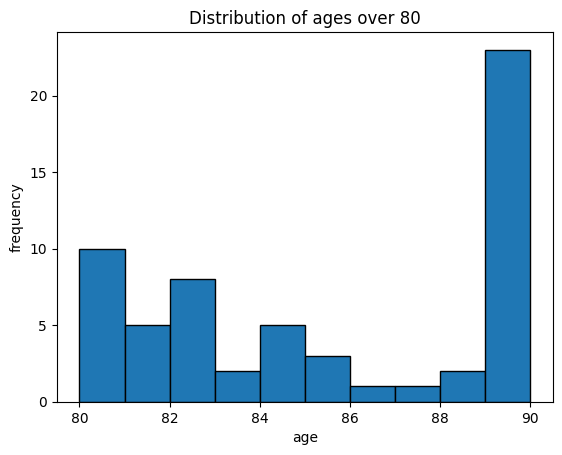

In [34]:
eighty_plus = adult.query("age >= 80")

plt.hist(eighty_plus["age"], edgecolor="black")
plt.xlabel("age")
plt.ylabel("frequency")
plt.title("Distribution of ages over 80")

print(
    """There are an inordinate number of rows where age = 90. This is likely due to all
ages > 90 being recorded as 90."""
)